Loading models and setting up...
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.11/site-packages/lpips/weights/v0.1/alex.pth


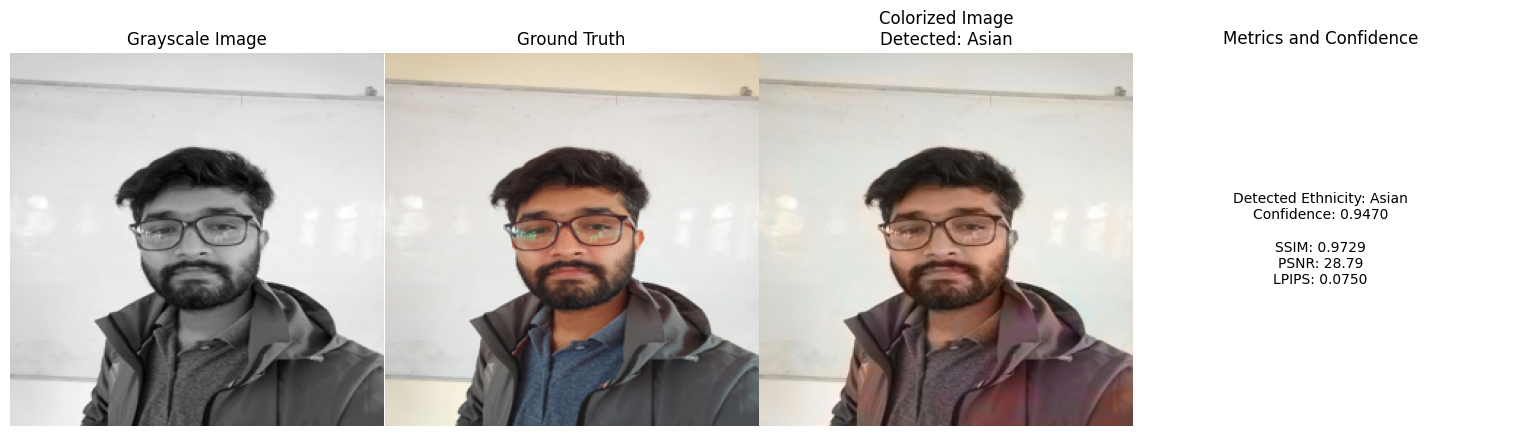

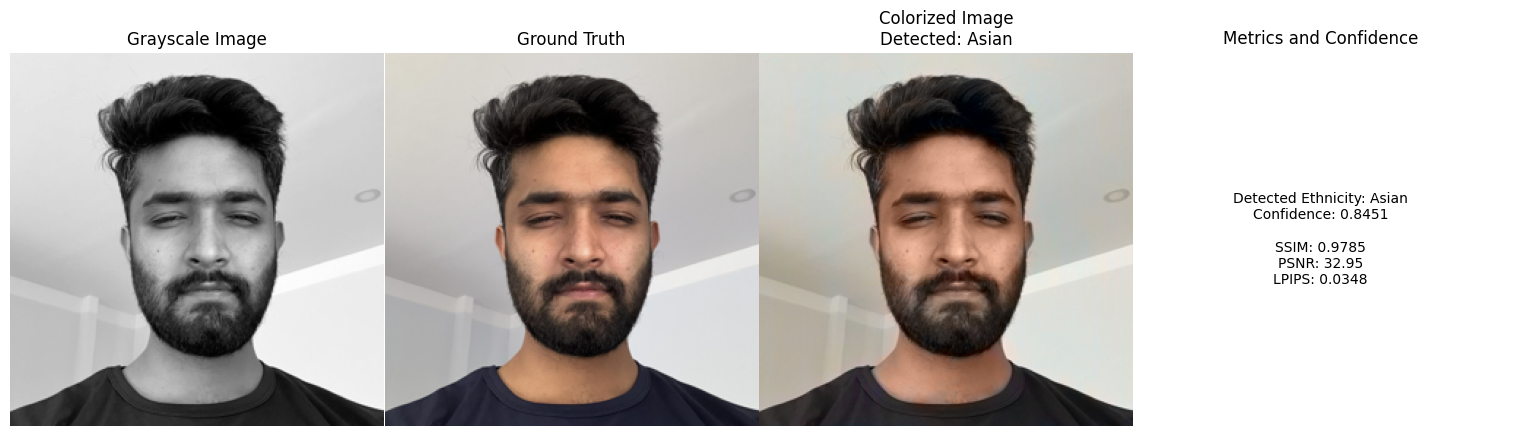

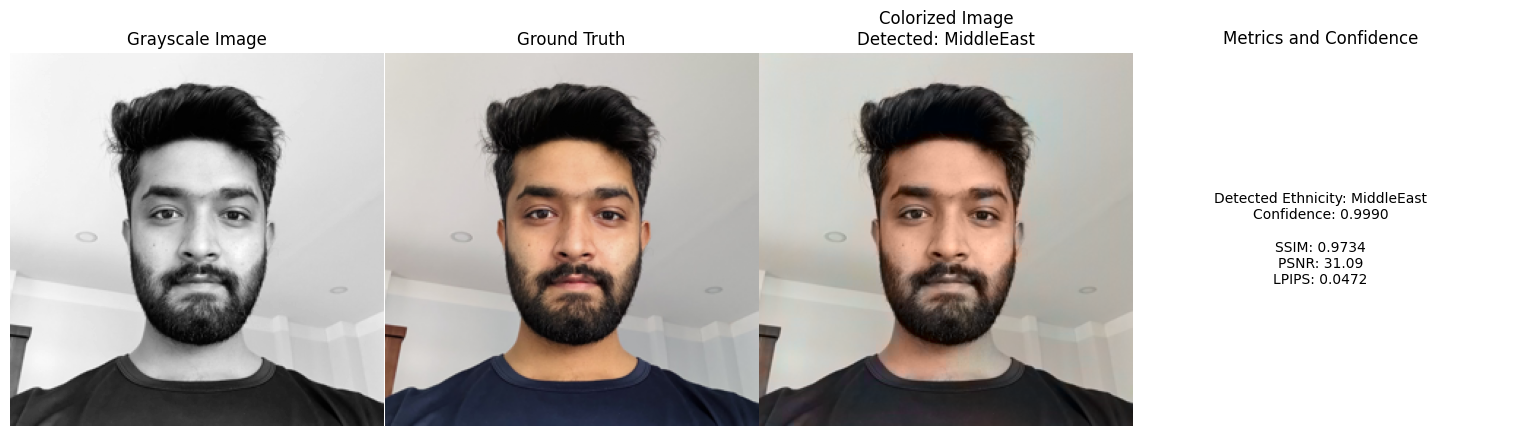

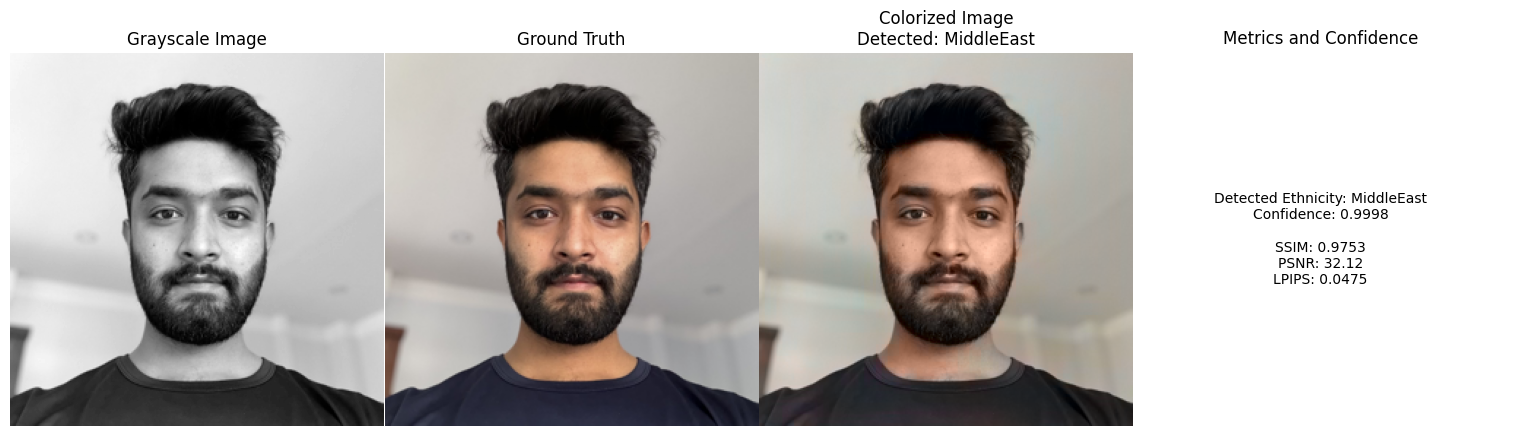

In [18]:
import os
import numpy as np
import tensorflow as tf
from PIL import Image
from skimage.color import rgb2lab, lab2rgb
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import lpips
import torch
from torchvision import transforms
from skimage.metrics import structural_similarity as ssim

# Define the custom PSNR metric
def psnr_metric(y_true, y_pred):
    return tf.image.psnr(y_true, y_pred, max_val=1.0)

# Define the custom SSIM metric
def ssim_metric(y_true, y_pred):
    return tf.image.ssim(y_true, y_pred, max_val=1.0)


print("Loading models and setting up...")

# Load the ethnicity detection model  - Pipeline 1
ethnicity_model = load_model('EthnicModel.h5')

# Load  the colorization model - Pipeline 2
colorization_model = load_model('ColorizeTuned.h5', custom_objects={'psnr_metric': psnr_metric, 'ssim_metric': ssim_metric})

# Initialize the LPIPS model
lpips_model = lpips.LPIPS(net='alex').eval()

# Function to load and preprocess the input image
def preprocess_image(image_path):
    image = Image.open(image_path).convert('RGB')
    image = image.resize((256, 256))
    image_np = np.array(image) / 255.0
    lab_image = rgb2lab(image_np)
    L_channel = lab_image[:, :, 0].reshape((256, 256, 1))
    
    return L_channel, image_np  # Return 1-channel grayscale and original RGB image

# Function to create a one-hot encoded class label
def create_one_hot_label(class_index, num_classes):
    one_hot_label = np.zeros((1, num_classes))
    one_hot_label[0, class_index] = 1
    return one_hot_label

# Function to calculate LPIPS
def load_image_for_lpips(image):
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])
    return transform(image).unsqueeze(0)  # Add batch dimension

# Enhanced function to display results with reduced spacing
def display_results_intuitive(image_path, class_names):
    # Preprocess the image for ethnicity detection (using RGB)
    _, rgb_image = preprocess_image(image_path)
    
    # Predict the ethnicity using the original RGB image, with verbosity turned off
    ethnicity_predictions = ethnicity_model.predict(rgb_image.reshape(1, 256, 256, 3), verbose=0)
    detected_class_index = np.argmax(ethnicity_predictions)
    detected_class_name = class_names[detected_class_index]
    confidence_score = ethnicity_predictions[0][detected_class_index]
    
    # Preprocess the image for colorization (using grayscale)
    L_channel, ground_truth = preprocess_image(image_path)
    
    # Create one-hot encoded label for the detected ethnicity
    one_hot_label = create_one_hot_label(detected_class_index, len(class_names))
    
    # Colorize the image using the detected ethnicity, with verbosity turned off
    predicted_ab = colorization_model.predict([L_channel.reshape(1, 256, 256, 1), one_hot_label], verbose=0)[0]
    
    # Combine L channel with predicted AB channels
    pred_lab_image = np.concatenate((L_channel, predicted_ab * 128), axis=-1)
    pred_rgb_image = lab2rgb(pred_lab_image)
    
    # Calculate SSIM, PSNR, and LPIPS metrics
    ssim_value = ssim(ground_truth, pred_rgb_image, channel_axis=2, data_range=1.0)
    psnr_value = tf.image.psnr(ground_truth, pred_rgb_image, max_val=1.0).numpy()
    lpips_value = lpips_model(load_image_for_lpips(Image.fromarray((ground_truth * 255).astype(np.uint8))), 
                              load_image_for_lpips(Image.fromarray((pred_rgb_image * 255).astype(np.uint8)))).item()
    
    # Enhanced display of results
    plt.figure(figsize=(15, 4))  # Adjusted figure size to reduce space
    
    plt.subplot(1, 4, 1)
    plt.imshow(L_channel.reshape(256, 256), cmap='gray')
    plt.title('Grayscale Image', fontsize=12)
    plt.axis('off')
    
    plt.subplot(1, 4, 2)
    plt.imshow(ground_truth)
    plt.title('Ground Truth', fontsize=12)
    plt.axis('off')
    
    plt.subplot(1, 4, 3)
    plt.imshow(pred_rgb_image)
    plt.title(f'Colorized Image\nDetected: {detected_class_name}', fontsize=12)
    plt.axis('off')
    
    plt.subplot(1, 4, 4)
    plt.text(0.5, 0.5, f'Detected Ethnicity: {detected_class_name}\n'
                       f'Confidence: {confidence_score:.4f}\n\n'
                       f'SSIM: {ssim_value:.4f}\n'
                       f'PSNR: {psnr_value:.2f}\n'
                       f'LPIPS: {lpips_value:.4f}', 
             horizontalalignment='center', verticalalignment='center', fontsize=10)
    plt.title('Metrics and Confidence', fontsize=12)
    plt.axis('off')
    
    plt.tight_layout(pad=0.1)  
    plt.show()

# Path to test images
test_image_dir = 'personal'  
class_names = ['Asian', 'Black', 'Indian', 'Latino', 'MiddleEast', 'White']

# Valid image extensions
valid_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.tiff')

# Iterate through test images and display results
for image_file in os.listdir(test_image_dir):
    if image_file.lower().endswith(valid_extensions):
        image_path = os.path.join(test_image_dir, image_file)
        display_results_intuitive(image_path, class_names)
